In [1]:
%matplotlib inline
from matplotlib import style, ticker
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
#Inspect the database
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'])

id
station
date
prcp
tobs


In [10]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'])

id
station
name
latitude
longitude
elevation


In [11]:
# Find the most recent date in the data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
last_date = last_date[0]

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
start_date = datetime.strptime(last_date, '%Y-%m-%d') - timedelta(days = 365)
start_date = start_date.date()

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date,Measurement.prcp).filter(Measurement.date >= start_date).all()
dates = [result[0] for result in results]
prcp = [result[1] for result in results]

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date', 'prcp'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df.sort_values(by='date', inplace=True)
df.head()

,prcp
date,
2016-08-23,0.00
2016-08-23,NaN
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15


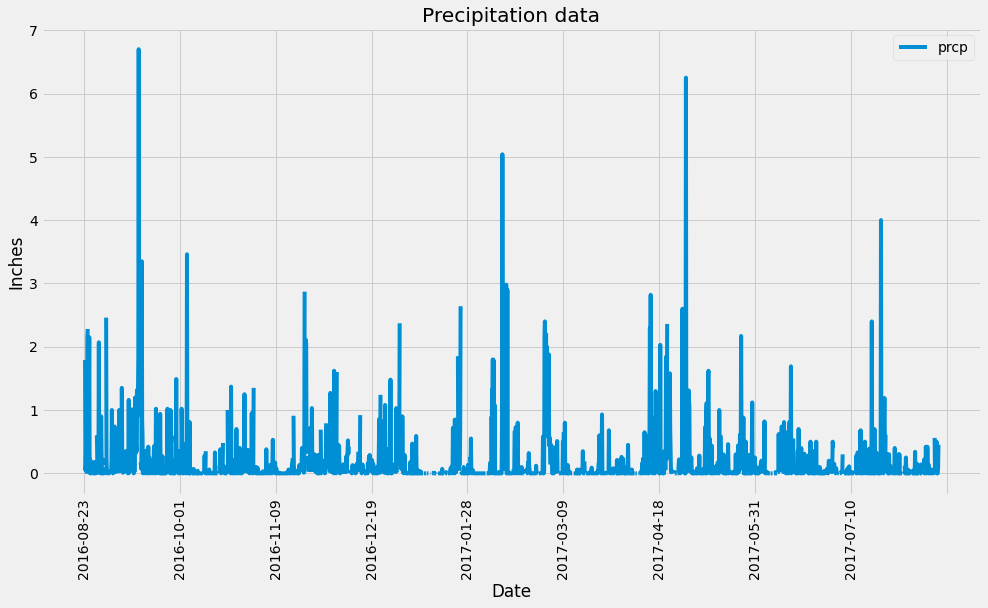

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = plt.axes()
ax.xaxis.set_major_locator(ticker.MultipleLocator(250))
df.plot(rot='vertical',figsize=(15,8), ax=ax)
plt.title("Precipitation data")
plt.xlabel("Date")
plt.ylabel("Inches")
plt.savefig("Images/PrecipitationData")
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()

,prcp
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(func.count(Station.station)).all()
print("Total number of stations: " + str(station_count[0][0]))

Total number of stations: 9


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
active_station = active_stations[0][0]
for stations in active_stations:
    print(f"Station: {stations[0]}  Count: {stations[1]}")

Station: USC00519281  Count: 2772
Station: USC00519397  Count: 2724
Station: USC00513117  Count: 2709
Station: USC00519523  Count: 2669
Station: USC00516128  Count: 2612
Station: USC00514830  Count: 2202
Station: USC00511918  Count: 1979
Station: USC00517948  Count: 1372
Station: USC00518838  Count: 511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
result = session.query(Measurement.station,\
              func.min(Measurement.tobs),\
              func.max(Measurement.tobs), \
              func.avg(Measurement.tobs)).filter(Measurement.station == active_station).all()
print(f"Most Active Station: {result[0][0]}")
print(f"Lowest temp: {result[0][1]}")
print(f"Highest temp: {result[0][2]}")
print(f"Mean temp: {round(result[0][3],2)}")

Most Active Station: USC00519281
Lowest temp: 54.0
Highest temp: 85.0
Mean temp: 71.66


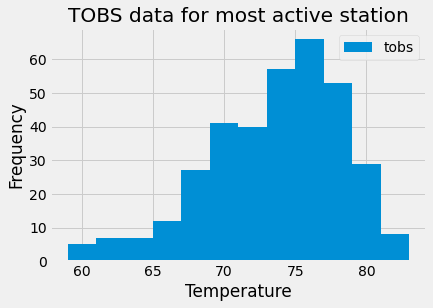

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs)\
            .filter(Measurement.station == active_station)\
            .filter(Measurement.date >= start_date).all()

tobs = list(np.ravel(results))
plt.hist(tobs, bins=12, label="tobs")
plt.title("TOBS data for most active station")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc='upper right')
plt.savefig("Images/TOBS_ActiveStation")
plt.show()

# Close session

In [19]:
# Close Session
session.close()